In order to know what I have modified, I put my code between :

 $#################
     MY CODE
 #################$

In [1]:
from __future__ import print_function, division

from keras.layers import Input, Dense, GaussianNoise, Concatenate, Lambda, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from keras import backend as K
import tensorflow as tf

import numpy as np
import argparse
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [2]:
gpus = tf.config.list_physical_devices('GPU')
gpus
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

In [3]:
# on compare juste si les messages sont égaux
# on ne regarder pas les bits mais juste les messages entre 0 et f on a autant d'erreur qu'entre 1 et 2

def compute_BLER(x,y):
    sh = x.shape
    p = sh[0]
    bler = 0
    for i in range(p):
        # Add the lines to evaluate the count wrongly decoded blocks
        argmax = np.argmax(y[i,:])
        if(x[i,argmax]==0):
            bler+=1
    return bler/p

In [4]:
# we don't have to touch this function
def customLayer(x):
    # You can implement any channel model
    return x

In [5]:
class AutoEncoder():
    def __init__(self, k, n, EbN0):

    
        # k = 4
        # n = 1 -> transmit one shot in the channel

        self.k = k  # k parameter, log2(M)
        self.num_enc_inputs = pow(2, self.k)  # M parameter = 2^k
        self.n = 2*n # to count for complex symbols
        self.num_hidden = self.n  # channel uses
        R = self.k / self.n # communication rate
        self.EbN0 = EbN0 # energy bit over noise power
        
        ##########################
        eps = np.sqrt(pow(10, -0.1 * self.EbN0) / (2 * 0.5))
        ##########################
        
        # Given the EbN0 in decibel, how to compute the noise power? N = ..

        optimizer = Adam(0.01, 0.5)

        # Build the transmitter
        self.transmitter = self.build_transmitter()

        # Build the receiver
        self.receiver = self.build_receiver()

        # The transmitter encodes the bits in s
        s_in = Input(shape=(self.num_enc_inputs,))
        x = self.transmitter(s_in)

        # Build the channel
        # contrainte dans la communication ->average power constraint
        x_n = BatchNormalization(axis=-1, center=False, scale=False)(x) # batch norm for AVERAGE POWER
        ch = Lambda(lambda x: customLayer(x))(x_n) # delta layer, customizable
        # channel + noise ! il faut trouver la function, c'est un layer
        # y = ... Look for the Gaussian noise layer
        
    
        ##########################
        y = GaussianNoise(stddev=eps)(ch)
        #########################
        
        # The receiver decodes the received code
        s_out = self.receiver(y)

        # The encoder model
        self.encoder = Model(s_in,y)

        # To extract BATCH NORM features
        x_inp = self.encoder.input
        outp = [layer.output for layer in self.encoder.layers[2:]]
        self.functor_input = K.function([x_inp], outp)

        # The decoder model
        y_in = Input(shape=(self.num_hidden,))
        s_dec = self.receiver(y_in)
        self.decoder = Model(y_in, s_dec)

        # To extract full input output
        y_inp = self.decoder.input
        s_outp = [layer.get_output_at(-1) for layer in self.decoder.layers[1:]]
        self.functor_output = K.function([y_inp], s_outp)

        # The combined model  (stacked encoder and decoder)
        self.combined = Model(s_in, s_out)
        
        # add the argument of the compile function  --> self.combined.compile(..)
        
        
        ##########################
        self.combined.compile(loss='categorical_crossentropy', optimizer=optimizer)
        ##########################

    def build_transmitter(self):

        model = Sequential()

        # ADD HERE YOUR TX DESIGN
        
        ######
        model.add(Dense(64, input_dim=self.num_enc_inputs))
        model.add(Activation('relu'))
        model.add(Dropout(0.3))
        
        
        model.add(Dense(128))
        model.add(Activation('relu'))
        model.add(Dropout(0.3))
        
    
        model.add(Dense(self.num_hidden))
        # it is also possible to delete this activation function but
        # the results are similar
        model.add(Activation('tanh'))
        ######

        model.summary()

        s_in = Input(shape=(self.num_enc_inputs,))
        x = model(s_in)

        return Model(s_in, x)

    def build_receiver(self):

        model = Sequential()

        # ADD HERE YOUR RX DESIGN
        
        
        ##########
     
        
        model.add(Dense(128,input_dim=self.num_hidden))
        model.add(Activation('relu'))
        model.add(Dropout(0.3))
        
        model.add(Dense(64))
        model.add(Activation('relu'))
        model.add(Dropout(0.3))
        
        model.add(Dense(self.num_enc_inputs, activation='softmax'))
        
        
        ##########

        model.summary()

        y = Input(shape=(self.num_hidden,))
        s_out = model(y)

        return Model(y, s_out)


    def train(self, epochs, batch_size=128):

        # ADD LINES BELOW
        # Find a way to defined s_in as one-hot vectors where all elements are equal to zero except one at the position representing the number.
        
        # batch size
        
        #####################
        s_in = np.zeros((epochs,self.num_enc_inputs),dtype=int)
        s_in_digit = np.zeros((epochs,1),dtype=int)
        for i in range(epochs):
            j = np.random.randint(self.num_enc_inputs,dtype=int,size=1)
            s_in[i,j] = 1
            
        ##################

        # traning auto encoder
        history =  self.combined.fit(s_in, s_in, epochs=epochs, batch_size=batch_size, verbose=0)
        full_loss = history.history["loss"]
        plt.plot(full_loss)
        plt.xlabel('Epoch')
        plt.title('Cross-entropy training loss')
        plt.show()

    def test(self, test_size):

        R = self.k/self.n
        # AWGN noise parameters initialization
        # Noise power definition .. -> N = ...
        
        ###########################
        N = pow(10, -0.1 * self.EbN0) / (2 * 0.5)
        ###########################
        
        mean_noise = np.zeros((self.n,))
        cov_noise = np.dot(N, np.eye(self.n))

        # As for the training process, define s_in as the one-hot input of the autoencoder 

        # test size
        
        s_in = np.zeros((test_size,self.num_enc_inputs),dtype=int)
        s_in_digit = np.zeros((test_size,1),dtype=int)
        for i in range(test_size):
            j = np.random.randint(self.num_enc_inputs,dtype=int,size=1)
            s_in_digit[i,:]=j
            s_in[i,j] = 1
            

        # extract the channel input including normalization layers
        layer_outs = self.functor_input([s_in])
        x = layer_outs[0] # channel input

        # add the channel, AWGN in this case
        noise = np.random.multivariate_normal(mean_noise, cov_noise, test_size)
        y = np.add(x, noise) # channel output
        
        
        # estimate the input message
        s_out = self.functor_output([y])
        # compute the block-error-rate
        
        bler = compute_BLER(s_in, s_out[0])


        return bler, s_in, x, y, s_out,s_in_digit

Actual SNR is:-20
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1088      
                                                                 
 activation (Activation)     (None, 64)                0         
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 activation_1 (Activation)   (None, 128)               0         
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 2)

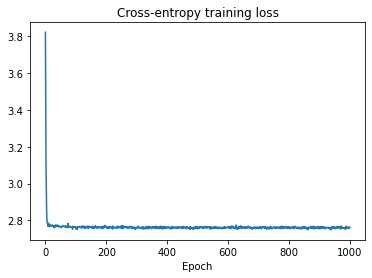

Actual SNR is:-19
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                1088      
                                                                 
 activation_5 (Activation)   (None, 64)                0         
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 128)               8320      
                                                                 
 activation_6 (Activation)   (None, 128)               0         
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 

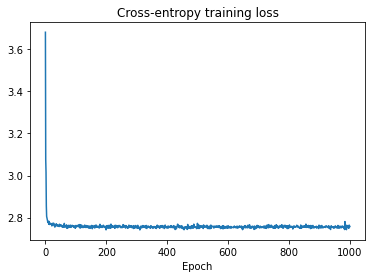

Actual SNR is:-18
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 64)                1088      
                                                                 
 activation_10 (Activation)  (None, 64)                0         
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 128)               8320      
                                                                 
 activation_11 (Activation)  (None, 128)               0         
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_14 (Dense)            (None, 

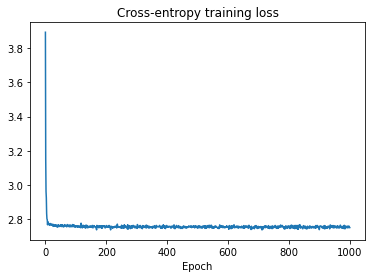

Actual SNR is:-17
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 64)                1088      
                                                                 
 activation_15 (Activation)  (None, 64)                0         
                                                                 
 dropout_12 (Dropout)        (None, 64)                0         
                                                                 
 dense_19 (Dense)            (None, 128)               8320      
                                                                 
 activation_16 (Activation)  (None, 128)               0         
                                                                 
 dropout_13 (Dropout)        (None, 128)               0         
                                                                 
 dense_20 (Dense)            (None, 

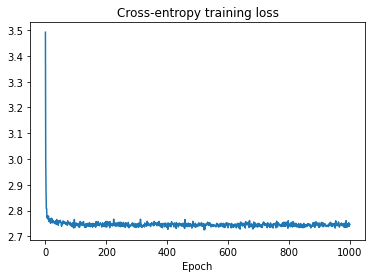

Actual SNR is:-16
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 64)                1088      
                                                                 
 activation_20 (Activation)  (None, 64)                0         
                                                                 
 dropout_16 (Dropout)        (None, 64)                0         
                                                                 
 dense_25 (Dense)            (None, 128)               8320      
                                                                 
 activation_21 (Activation)  (None, 128)               0         
                                                                 
 dropout_17 (Dropout)        (None, 128)               0         
                                                                 
 dense_26 (Dense)            (None, 

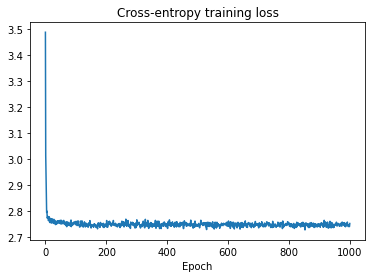

Actual SNR is:-15
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 64)                1088      
                                                                 
 activation_25 (Activation)  (None, 64)                0         
                                                                 
 dropout_20 (Dropout)        (None, 64)                0         
                                                                 
 dense_31 (Dense)            (None, 128)               8320      
                                                                 
 activation_26 (Activation)  (None, 128)               0         
                                                                 
 dropout_21 (Dropout)        (None, 128)               0         
                                                                 
 dense_32 (Dense)            (None,

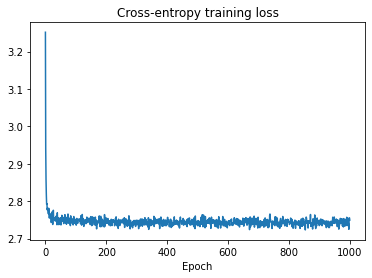

Actual SNR is:-14
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 64)                1088      
                                                                 
 activation_30 (Activation)  (None, 64)                0         
                                                                 
 dropout_24 (Dropout)        (None, 64)                0         
                                                                 
 dense_37 (Dense)            (None, 128)               8320      
                                                                 
 activation_31 (Activation)  (None, 128)               0         
                                                                 
 dropout_25 (Dropout)        (None, 128)               0         
                                                                 
 dense_38 (Dense)            (None,

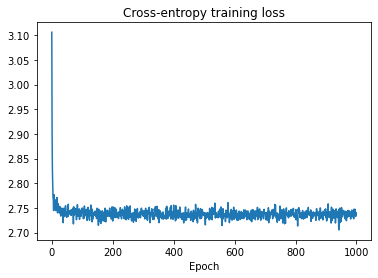

Actual SNR is:-13
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_42 (Dense)            (None, 64)                1088      
                                                                 
 activation_35 (Activation)  (None, 64)                0         
                                                                 
 dropout_28 (Dropout)        (None, 64)                0         
                                                                 
 dense_43 (Dense)            (None, 128)               8320      
                                                                 
 activation_36 (Activation)  (None, 128)               0         
                                                                 
 dropout_29 (Dropout)        (None, 128)               0         
                                                                 
 dense_44 (Dense)            (None,

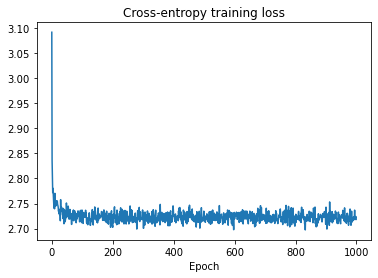

Actual SNR is:-12
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (None, 64)                1088      
                                                                 
 activation_40 (Activation)  (None, 64)                0         
                                                                 
 dropout_32 (Dropout)        (None, 64)                0         
                                                                 
 dense_49 (Dense)            (None, 128)               8320      
                                                                 
 activation_41 (Activation)  (None, 128)               0         
                                                                 
 dropout_33 (Dropout)        (None, 128)               0         
                                                                 
 dense_50 (Dense)            (None,

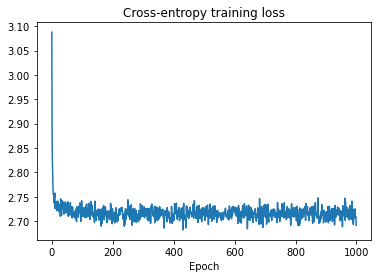

Actual SNR is:-11
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_54 (Dense)            (None, 64)                1088      
                                                                 
 activation_45 (Activation)  (None, 64)                0         
                                                                 
 dropout_36 (Dropout)        (None, 64)                0         
                                                                 
 dense_55 (Dense)            (None, 128)               8320      
                                                                 
 activation_46 (Activation)  (None, 128)               0         
                                                                 
 dropout_37 (Dropout)        (None, 128)               0         
                                                                 
 dense_56 (Dense)            (None,

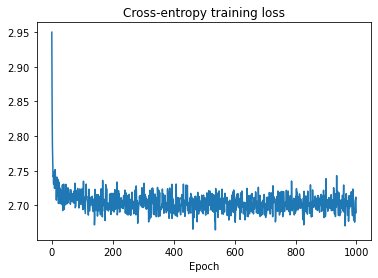

Actual SNR is:-10
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_60 (Dense)            (None, 64)                1088      
                                                                 
 activation_50 (Activation)  (None, 64)                0         
                                                                 
 dropout_40 (Dropout)        (None, 64)                0         
                                                                 
 dense_61 (Dense)            (None, 128)               8320      
                                                                 
 activation_51 (Activation)  (None, 128)               0         
                                                                 
 dropout_41 (Dropout)        (None, 128)               0         
                                                                 
 dense_62 (Dense)            (None,

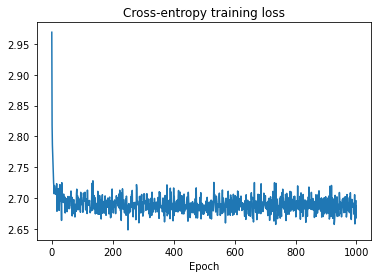

Actual SNR is:-9
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_66 (Dense)            (None, 64)                1088      
                                                                 
 activation_55 (Activation)  (None, 64)                0         
                                                                 
 dropout_44 (Dropout)        (None, 64)                0         
                                                                 
 dense_67 (Dense)            (None, 128)               8320      
                                                                 
 activation_56 (Activation)  (None, 128)               0         
                                                                 
 dropout_45 (Dropout)        (None, 128)               0         
                                                                 
 dense_68 (Dense)            (None, 

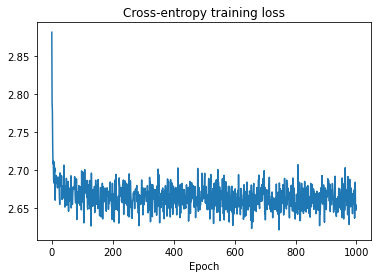

Actual SNR is:-8
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_72 (Dense)            (None, 64)                1088      
                                                                 
 activation_60 (Activation)  (None, 64)                0         
                                                                 
 dropout_48 (Dropout)        (None, 64)                0         
                                                                 
 dense_73 (Dense)            (None, 128)               8320      
                                                                 
 activation_61 (Activation)  (None, 128)               0         
                                                                 
 dropout_49 (Dropout)        (None, 128)               0         
                                                                 
 dense_74 (Dense)            (None, 

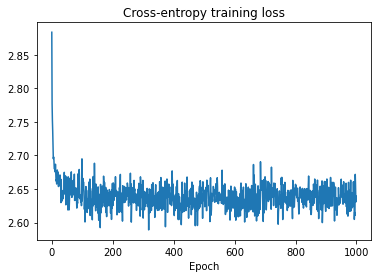

Actual SNR is:-7
Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_78 (Dense)            (None, 64)                1088      
                                                                 
 activation_65 (Activation)  (None, 64)                0         
                                                                 
 dropout_52 (Dropout)        (None, 64)                0         
                                                                 
 dense_79 (Dense)            (None, 128)               8320      
                                                                 
 activation_66 (Activation)  (None, 128)               0         
                                                                 
 dropout_53 (Dropout)        (None, 128)               0         
                                                                 
 dense_80 (Dense)            (None, 

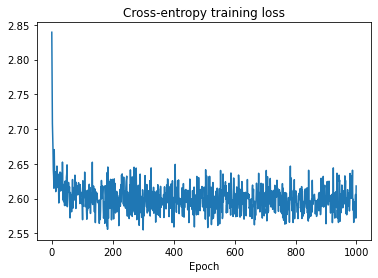

Actual SNR is:-6
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_84 (Dense)            (None, 64)                1088      
                                                                 
 activation_70 (Activation)  (None, 64)                0         
                                                                 
 dropout_56 (Dropout)        (None, 64)                0         
                                                                 
 dense_85 (Dense)            (None, 128)               8320      
                                                                 
 activation_71 (Activation)  (None, 128)               0         
                                                                 
 dropout_57 (Dropout)        (None, 128)               0         
                                                                 
 dense_86 (Dense)            (None, 

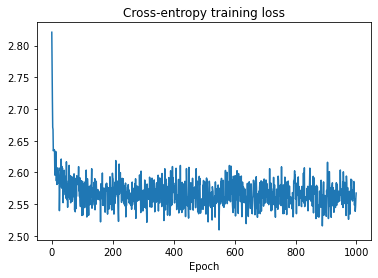

Actual SNR is:-5
Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_90 (Dense)            (None, 64)                1088      
                                                                 
 activation_75 (Activation)  (None, 64)                0         
                                                                 
 dropout_60 (Dropout)        (None, 64)                0         
                                                                 
 dense_91 (Dense)            (None, 128)               8320      
                                                                 
 activation_76 (Activation)  (None, 128)               0         
                                                                 
 dropout_61 (Dropout)        (None, 128)               0         
                                                                 
 dense_92 (Dense)            (None, 

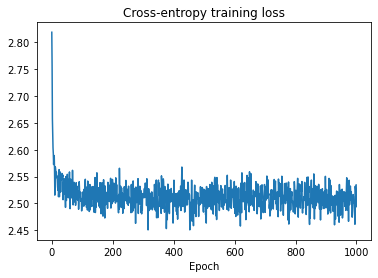

Actual SNR is:-4
Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_96 (Dense)            (None, 64)                1088      
                                                                 
 activation_80 (Activation)  (None, 64)                0         
                                                                 
 dropout_64 (Dropout)        (None, 64)                0         
                                                                 
 dense_97 (Dense)            (None, 128)               8320      
                                                                 
 activation_81 (Activation)  (None, 128)               0         
                                                                 
 dropout_65 (Dropout)        (None, 128)               0         
                                                                 
 dense_98 (Dense)            (None, 

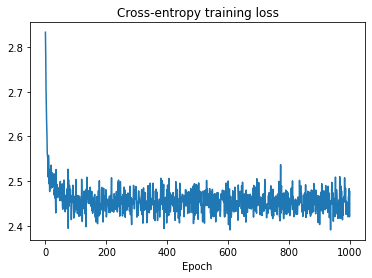

Actual SNR is:-3
Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_102 (Dense)           (None, 64)                1088      
                                                                 
 activation_85 (Activation)  (None, 64)                0         
                                                                 
 dropout_68 (Dropout)        (None, 64)                0         
                                                                 
 dense_103 (Dense)           (None, 128)               8320      
                                                                 
 activation_86 (Activation)  (None, 128)               0         
                                                                 
 dropout_69 (Dropout)        (None, 128)               0         
                                                                 
 dense_104 (Dense)           (None, 

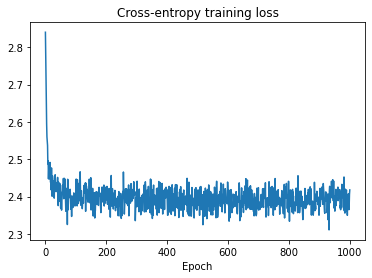

Actual SNR is:-2
Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_108 (Dense)           (None, 64)                1088      
                                                                 
 activation_90 (Activation)  (None, 64)                0         
                                                                 
 dropout_72 (Dropout)        (None, 64)                0         
                                                                 
 dense_109 (Dense)           (None, 128)               8320      
                                                                 
 activation_91 (Activation)  (None, 128)               0         
                                                                 
 dropout_73 (Dropout)        (None, 128)               0         
                                                                 
 dense_110 (Dense)           (None, 

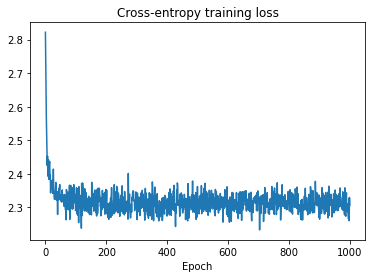

Actual SNR is:-1
Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_114 (Dense)           (None, 64)                1088      
                                                                 
 activation_95 (Activation)  (None, 64)                0         
                                                                 
 dropout_76 (Dropout)        (None, 64)                0         
                                                                 
 dense_115 (Dense)           (None, 128)               8320      
                                                                 
 activation_96 (Activation)  (None, 128)               0         
                                                                 
 dropout_77 (Dropout)        (None, 128)               0         
                                                                 
 dense_116 (Dense)           (None, 

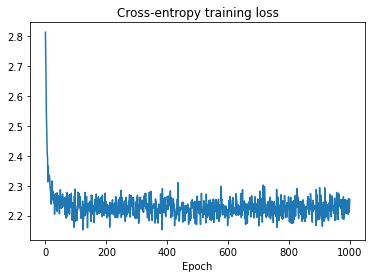

Actual SNR is:0
Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_120 (Dense)           (None, 64)                1088      
                                                                 
 activation_100 (Activation)  (None, 64)               0         
                                                                 
 dropout_80 (Dropout)        (None, 64)                0         
                                                                 
 dense_121 (Dense)           (None, 128)               8320      
                                                                 
 activation_101 (Activation)  (None, 128)              0         
                                                                 
 dropout_81 (Dropout)        (None, 128)               0         
                                                                 
 dense_122 (Dense)           (None, 2

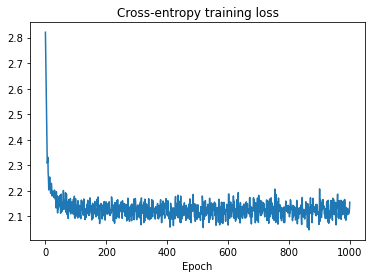

Actual SNR is:1
Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_126 (Dense)           (None, 64)                1088      
                                                                 
 activation_105 (Activation)  (None, 64)               0         
                                                                 
 dropout_84 (Dropout)        (None, 64)                0         
                                                                 
 dense_127 (Dense)           (None, 128)               8320      
                                                                 
 activation_106 (Activation)  (None, 128)              0         
                                                                 
 dropout_85 (Dropout)        (None, 128)               0         
                                                                 
 dense_128 (Dense)           (None, 2

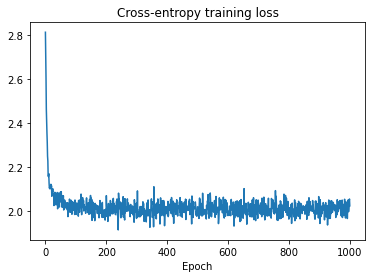

Actual SNR is:2
Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_132 (Dense)           (None, 64)                1088      
                                                                 
 activation_110 (Activation)  (None, 64)               0         
                                                                 
 dropout_88 (Dropout)        (None, 64)                0         
                                                                 
 dense_133 (Dense)           (None, 128)               8320      
                                                                 
 activation_111 (Activation)  (None, 128)              0         
                                                                 
 dropout_89 (Dropout)        (None, 128)               0         
                                                                 
 dense_134 (Dense)           (None, 2

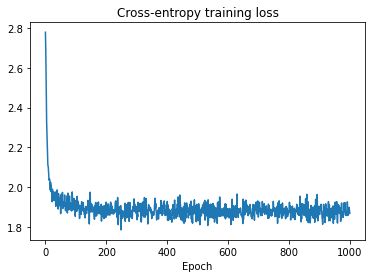

Actual SNR is:3
Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_138 (Dense)           (None, 64)                1088      
                                                                 
 activation_115 (Activation)  (None, 64)               0         
                                                                 
 dropout_92 (Dropout)        (None, 64)                0         
                                                                 
 dense_139 (Dense)           (None, 128)               8320      
                                                                 
 activation_116 (Activation)  (None, 128)              0         
                                                                 
 dropout_93 (Dropout)        (None, 128)               0         
                                                                 
 dense_140 (Dense)           (None, 2

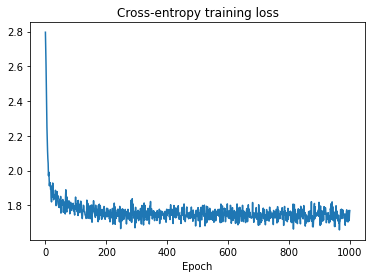

Actual SNR is:4
Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_144 (Dense)           (None, 64)                1088      
                                                                 
 activation_120 (Activation)  (None, 64)               0         
                                                                 
 dropout_96 (Dropout)        (None, 64)                0         
                                                                 
 dense_145 (Dense)           (None, 128)               8320      
                                                                 
 activation_121 (Activation)  (None, 128)              0         
                                                                 
 dropout_97 (Dropout)        (None, 128)               0         
                                                                 
 dense_146 (Dense)           (None, 2

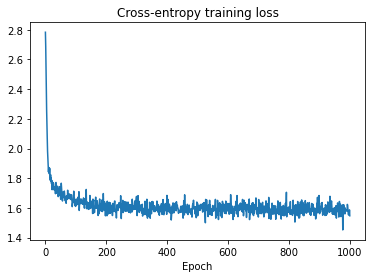

Actual SNR is:5
Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_150 (Dense)           (None, 64)                1088      
                                                                 
 activation_125 (Activation)  (None, 64)               0         
                                                                 
 dropout_100 (Dropout)       (None, 64)                0         
                                                                 
 dense_151 (Dense)           (None, 128)               8320      
                                                                 
 activation_126 (Activation)  (None, 128)              0         
                                                                 
 dropout_101 (Dropout)       (None, 128)               0         
                                                                 
 dense_152 (Dense)           (None, 2

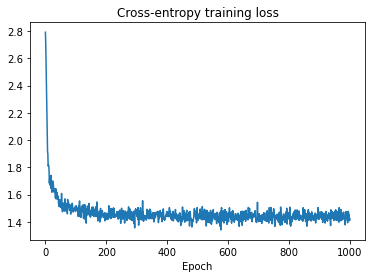

Actual SNR is:6
Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_156 (Dense)           (None, 64)                1088      
                                                                 
 activation_130 (Activation)  (None, 64)               0         
                                                                 
 dropout_104 (Dropout)       (None, 64)                0         
                                                                 
 dense_157 (Dense)           (None, 128)               8320      
                                                                 
 activation_131 (Activation)  (None, 128)              0         
                                                                 
 dropout_105 (Dropout)       (None, 128)               0         
                                                                 
 dense_158 (Dense)           (None, 2

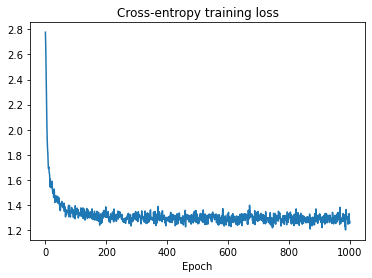

Actual SNR is:7
Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_162 (Dense)           (None, 64)                1088      
                                                                 
 activation_135 (Activation)  (None, 64)               0         
                                                                 
 dropout_108 (Dropout)       (None, 64)                0         
                                                                 
 dense_163 (Dense)           (None, 128)               8320      
                                                                 
 activation_136 (Activation)  (None, 128)              0         
                                                                 
 dropout_109 (Dropout)       (None, 128)               0         
                                                                 
 dense_164 (Dense)           (None, 2

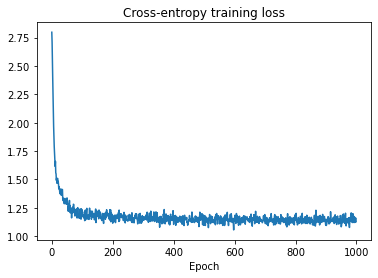

Actual SNR is:8
Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_168 (Dense)           (None, 64)                1088      
                                                                 
 activation_140 (Activation)  (None, 64)               0         
                                                                 
 dropout_112 (Dropout)       (None, 64)                0         
                                                                 
 dense_169 (Dense)           (None, 128)               8320      
                                                                 
 activation_141 (Activation)  (None, 128)              0         
                                                                 
 dropout_113 (Dropout)       (None, 128)               0         
                                                                 
 dense_170 (Dense)           (None, 2

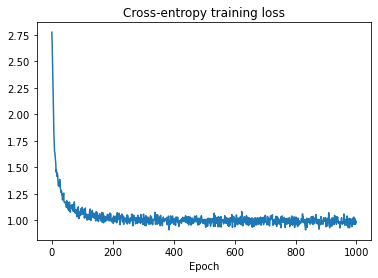

Actual SNR is:9
Model: "sequential_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_174 (Dense)           (None, 64)                1088      
                                                                 
 activation_145 (Activation)  (None, 64)               0         
                                                                 
 dropout_116 (Dropout)       (None, 64)                0         
                                                                 
 dense_175 (Dense)           (None, 128)               8320      
                                                                 
 activation_146 (Activation)  (None, 128)              0         
                                                                 
 dropout_117 (Dropout)       (None, 128)               0         
                                                                 
 dense_176 (Dense)           (None, 2

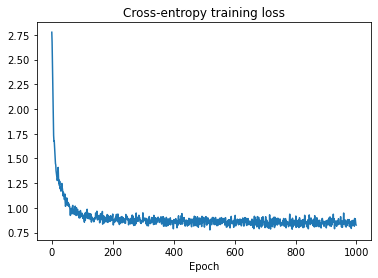

Actual SNR is:10
Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_180 (Dense)           (None, 64)                1088      
                                                                 
 activation_150 (Activation)  (None, 64)               0         
                                                                 
 dropout_120 (Dropout)       (None, 64)                0         
                                                                 
 dense_181 (Dense)           (None, 128)               8320      
                                                                 
 activation_151 (Activation)  (None, 128)              0         
                                                                 
 dropout_121 (Dropout)       (None, 128)               0         
                                                                 
 dense_182 (Dense)           (None, 

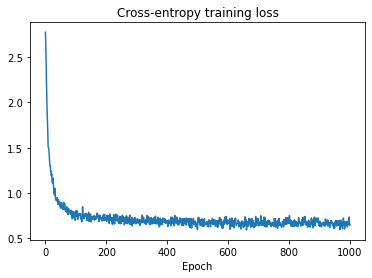

Actual SNR is:11
Model: "sequential_62"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_186 (Dense)           (None, 64)                1088      
                                                                 
 activation_155 (Activation)  (None, 64)               0         
                                                                 
 dropout_124 (Dropout)       (None, 64)                0         
                                                                 
 dense_187 (Dense)           (None, 128)               8320      
                                                                 
 activation_156 (Activation)  (None, 128)              0         
                                                                 
 dropout_125 (Dropout)       (None, 128)               0         
                                                                 
 dense_188 (Dense)           (None, 

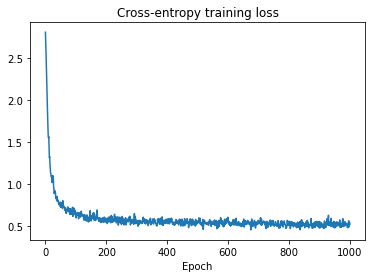

Actual SNR is:12
Model: "sequential_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_192 (Dense)           (None, 64)                1088      
                                                                 
 activation_160 (Activation)  (None, 64)               0         
                                                                 
 dropout_128 (Dropout)       (None, 64)                0         
                                                                 
 dense_193 (Dense)           (None, 128)               8320      
                                                                 
 activation_161 (Activation)  (None, 128)              0         
                                                                 
 dropout_129 (Dropout)       (None, 128)               0         
                                                                 
 dense_194 (Dense)           (None, 

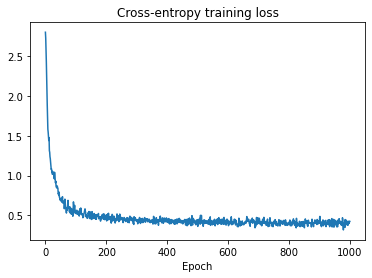

Actual SNR is:13
Model: "sequential_66"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_198 (Dense)           (None, 64)                1088      
                                                                 
 activation_165 (Activation)  (None, 64)               0         
                                                                 
 dropout_132 (Dropout)       (None, 64)                0         
                                                                 
 dense_199 (Dense)           (None, 128)               8320      
                                                                 
 activation_166 (Activation)  (None, 128)              0         
                                                                 
 dropout_133 (Dropout)       (None, 128)               0         
                                                                 
 dense_200 (Dense)           (None, 

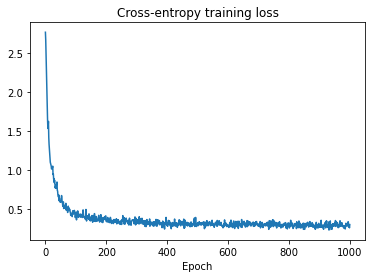

Actual SNR is:14
Model: "sequential_68"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_204 (Dense)           (None, 64)                1088      
                                                                 
 activation_170 (Activation)  (None, 64)               0         
                                                                 
 dropout_136 (Dropout)       (None, 64)                0         
                                                                 
 dense_205 (Dense)           (None, 128)               8320      
                                                                 
 activation_171 (Activation)  (None, 128)              0         
                                                                 
 dropout_137 (Dropout)       (None, 128)               0         
                                                                 
 dense_206 (Dense)           (None, 

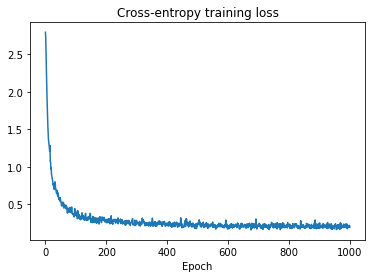

Actual SNR is:15
Model: "sequential_70"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_210 (Dense)           (None, 64)                1088      
                                                                 
 activation_175 (Activation)  (None, 64)               0         
                                                                 
 dropout_140 (Dropout)       (None, 64)                0         
                                                                 
 dense_211 (Dense)           (None, 128)               8320      
                                                                 
 activation_176 (Activation)  (None, 128)              0         
                                                                 
 dropout_141 (Dropout)       (None, 128)               0         
                                                                 
 dense_212 (Dense)           (None, 

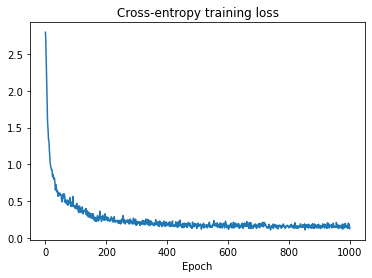

Actual SNR is:16
Model: "sequential_72"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_216 (Dense)           (None, 64)                1088      
                                                                 
 activation_180 (Activation)  (None, 64)               0         
                                                                 
 dropout_144 (Dropout)       (None, 64)                0         
                                                                 
 dense_217 (Dense)           (None, 128)               8320      
                                                                 
 activation_181 (Activation)  (None, 128)              0         
                                                                 
 dropout_145 (Dropout)       (None, 128)               0         
                                                                 
 dense_218 (Dense)           (None, 

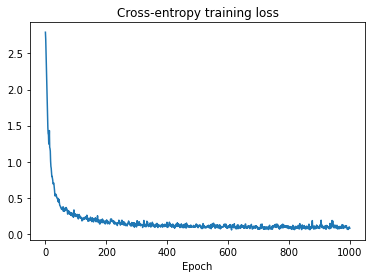

Actual SNR is:17
Model: "sequential_74"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_222 (Dense)           (None, 64)                1088      
                                                                 
 activation_185 (Activation)  (None, 64)               0         
                                                                 
 dropout_148 (Dropout)       (None, 64)                0         
                                                                 
 dense_223 (Dense)           (None, 128)               8320      
                                                                 
 activation_186 (Activation)  (None, 128)              0         
                                                                 
 dropout_149 (Dropout)       (None, 128)               0         
                                                                 
 dense_224 (Dense)           (None, 

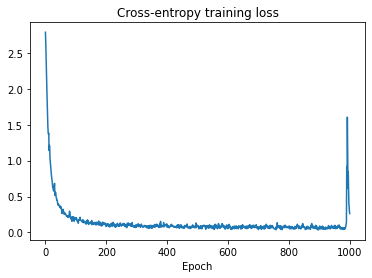

Actual SNR is:18
Model: "sequential_76"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_228 (Dense)           (None, 64)                1088      
                                                                 
 activation_190 (Activation)  (None, 64)               0         
                                                                 
 dropout_152 (Dropout)       (None, 64)                0         
                                                                 
 dense_229 (Dense)           (None, 128)               8320      
                                                                 
 activation_191 (Activation)  (None, 128)              0         
                                                                 
 dropout_153 (Dropout)       (None, 128)               0         
                                                                 
 dense_230 (Dense)           (None, 

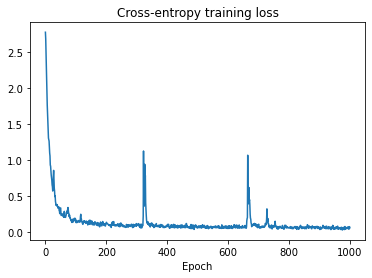

Actual SNR is:19
Model: "sequential_78"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_234 (Dense)           (None, 64)                1088      
                                                                 
 activation_195 (Activation)  (None, 64)               0         
                                                                 
 dropout_156 (Dropout)       (None, 64)                0         
                                                                 
 dense_235 (Dense)           (None, 128)               8320      
                                                                 
 activation_196 (Activation)  (None, 128)              0         
                                                                 
 dropout_157 (Dropout)       (None, 128)               0         
                                                                 
 dense_236 (Dense)           (None, 

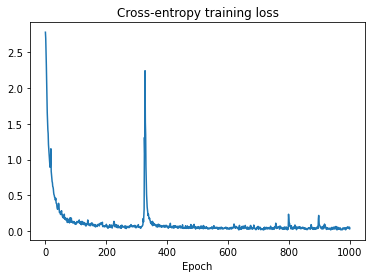

Actual SNR is:20
Model: "sequential_80"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_240 (Dense)           (None, 64)                1088      
                                                                 
 activation_200 (Activation)  (None, 64)               0         
                                                                 
 dropout_160 (Dropout)       (None, 64)                0         
                                                                 
 dense_241 (Dense)           (None, 128)               8320      
                                                                 
 activation_201 (Activation)  (None, 128)              0         
                                                                 
 dropout_161 (Dropout)       (None, 128)               0         
                                                                 
 dense_242 (Dense)           (None, 

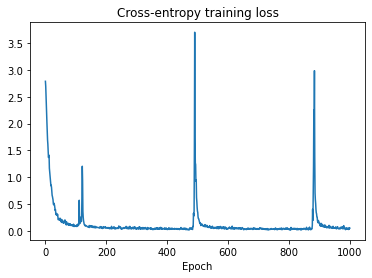

In [6]:
batch_size = 10000
epochs = 1000
test_size = 500

k = 4 # entropy of the source, block-size
n = 1 # channel uses
SNR_dB = range(-20,21)
#SNR_dB = range(0,21,10) # training range

bler_total = np.zeros((len(SNR_dB),1))
x_total = np.zeros((len(SNR_dB),test_size,2*n))
y_total = np.zeros((len(SNR_dB),test_size,2*n))
s_input = np.zeros((len(SNR_dB),test_size,1))

j = 0
for SNR in SNR_dB:
    print(f'Actual SNR is:{SNR}')
    # Initialize dDIME
    ae = AutoEncoder(k,n,SNR)
    # Train
    ae.train(epochs=epochs, batch_size=batch_size)
    # Test
    bler, _, x, y,_,s_in_digit = ae.test(test_size=test_size)
    bler_total[j,0] = bler
    x_total[j] = x
    y_total[j] = y
    s_input[j] = s_in_digit
    del ae
    j = j+1

# Select what do you want to plot based on the output of the test function and based on the assignment requests

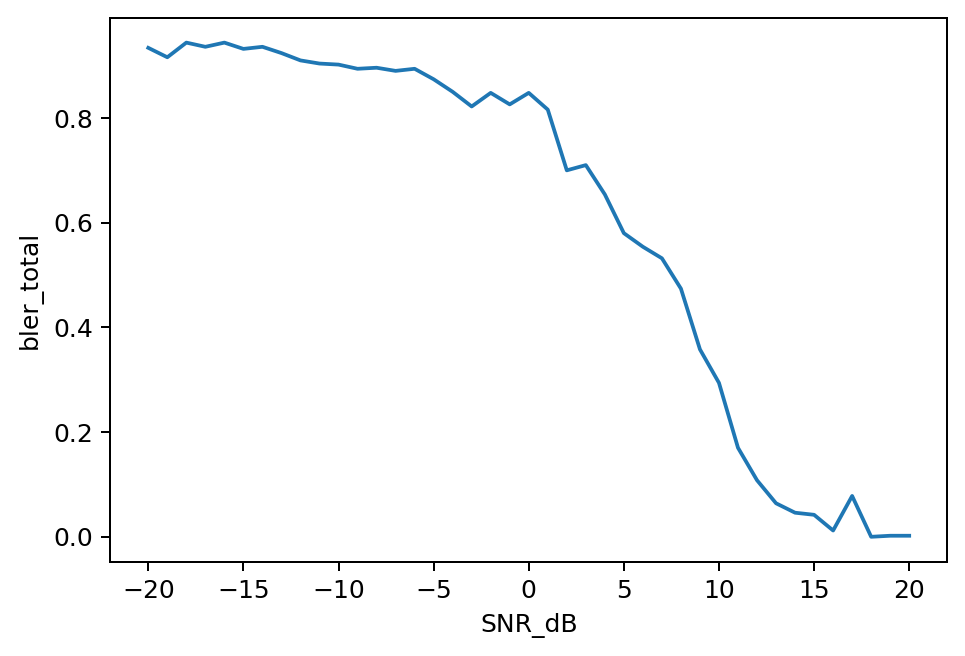

In [7]:
plt.figure(figsize=(6, 4), dpi=180)
plt.plot(SNR_dB, bler_total)
plt.xlabel("SNR_dB")
plt.ylabel("bler_total")
plt.show()

We can display the values before the channel

-20


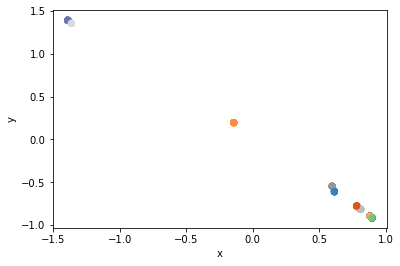

-19


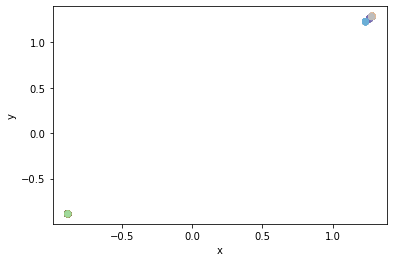

-18


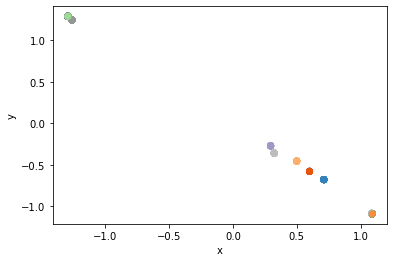

-17


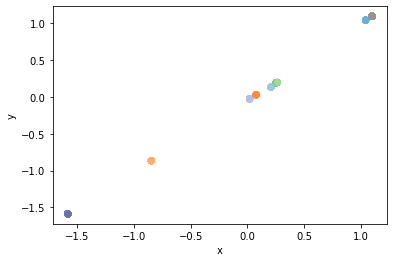

-16


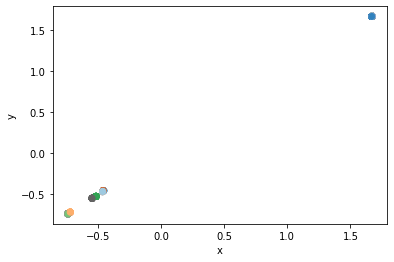

-15


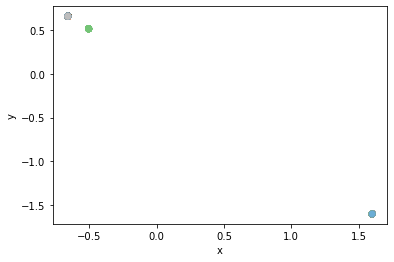

-14


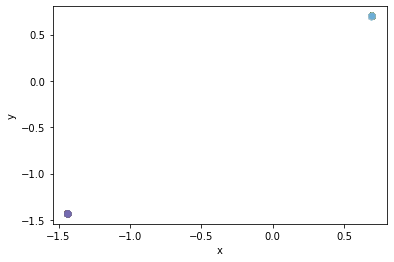

-13


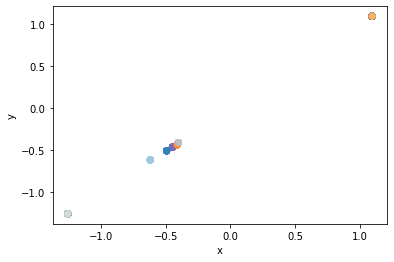

-12


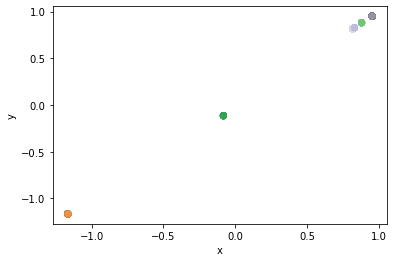

-11


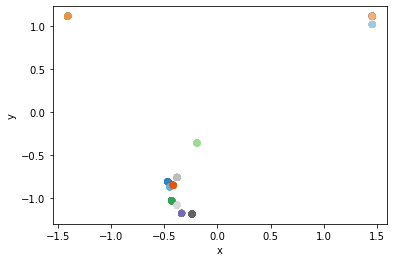

-10


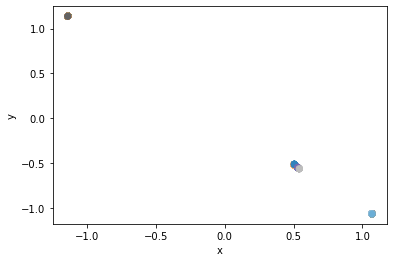

-9


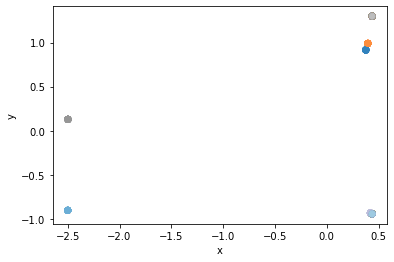

-8


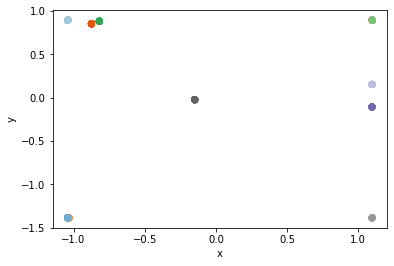

-7


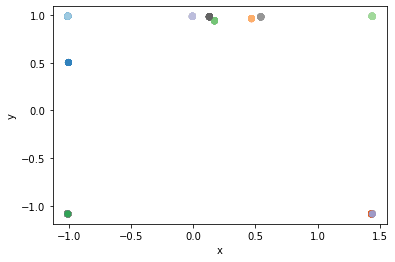

-6


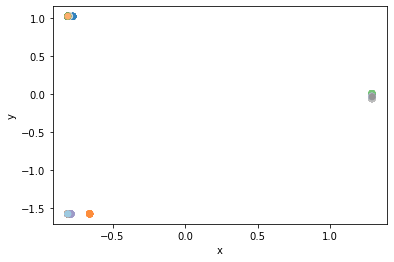

-5


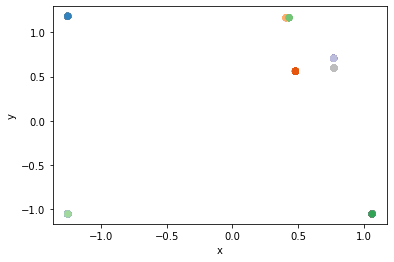

-4


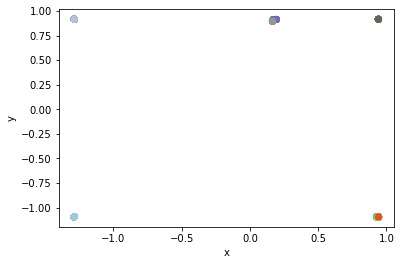

-3


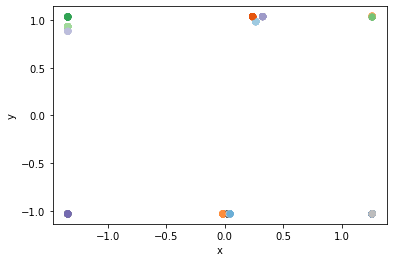

-2


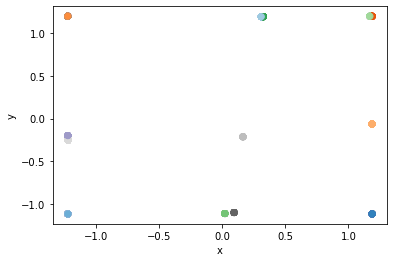

-1


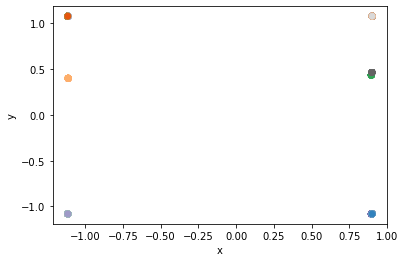

0


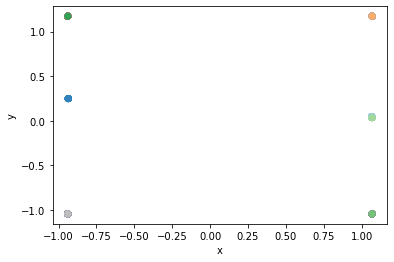

1


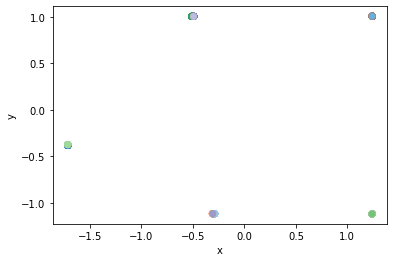

2


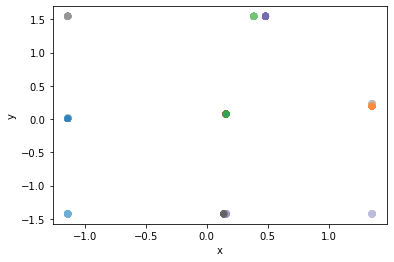

3


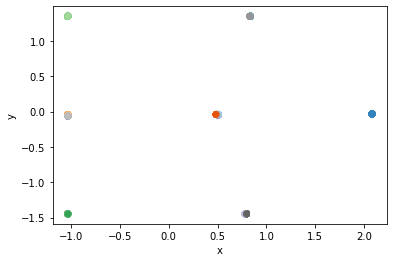

4


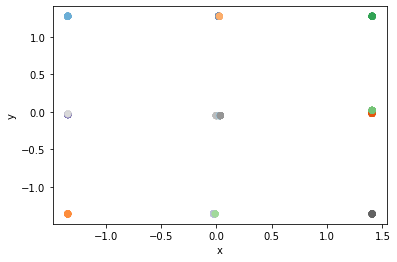

5


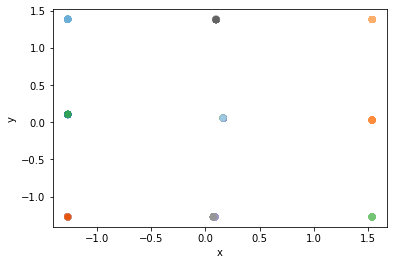

6


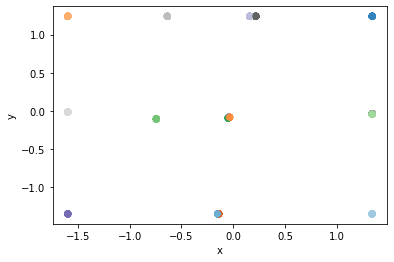

7


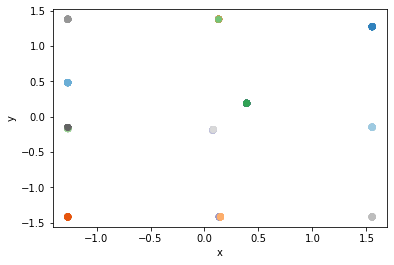

8


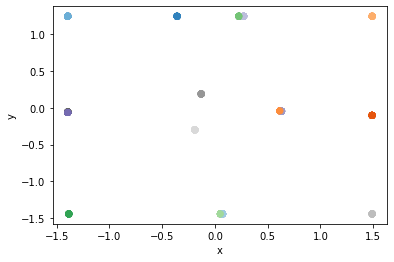

9


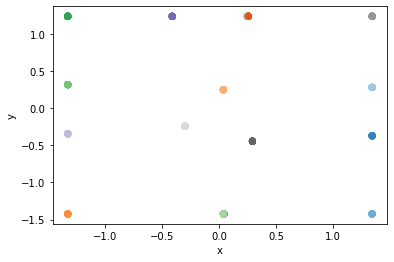

10


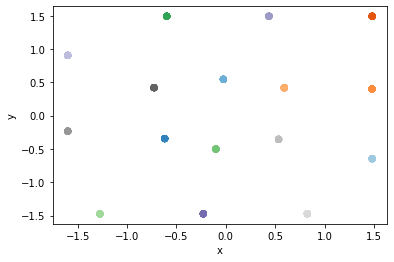

11


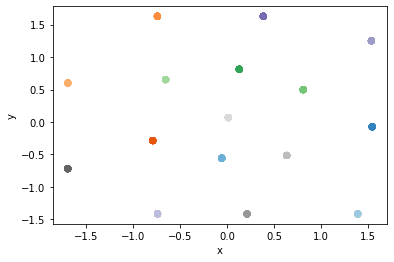

12


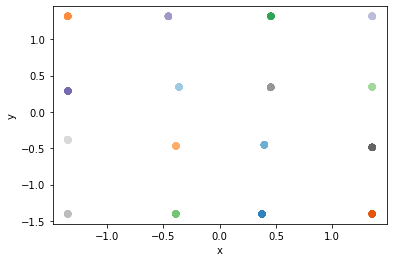

13


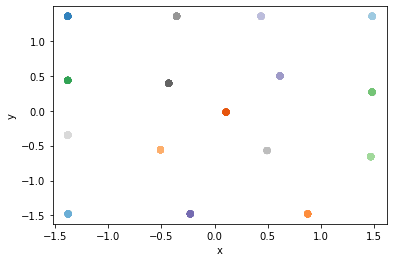

14


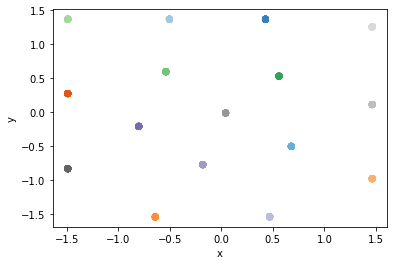

15


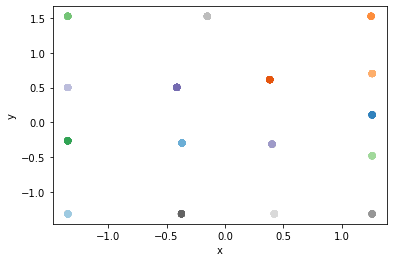

16


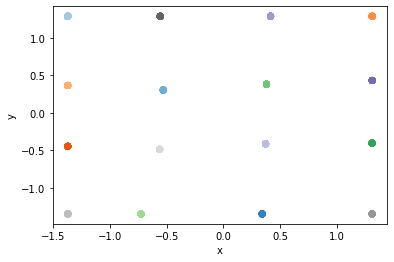

17


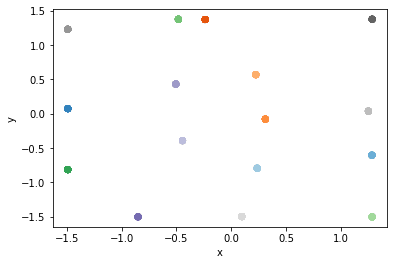

18


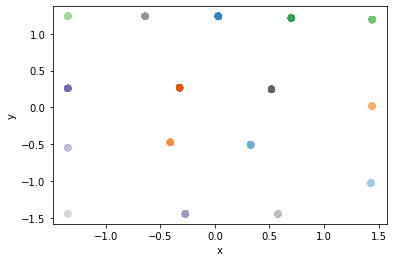

19


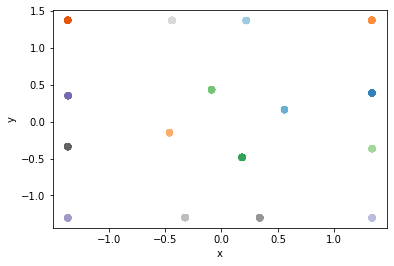

20


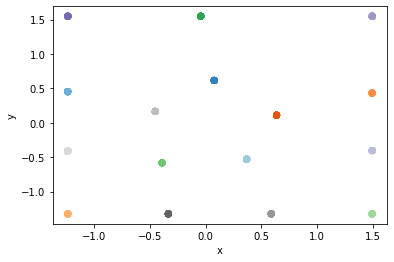

In [8]:
for i in range(len(SNR_dB)):
    print(SNR_dB[i])
    plt.figure()
    plt.scatter(x_total[i,:,0], x_total[i,:,1],c=s_input[i],cmap=plt.get_cmap('tab20c'))
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()


Then we can see the message after the channel. We have normal distribution aournd the cluster we found before.

-20


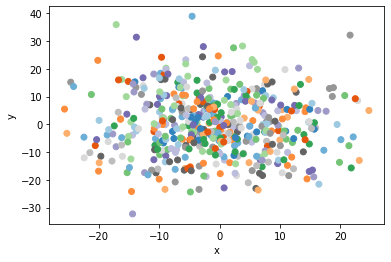

-19


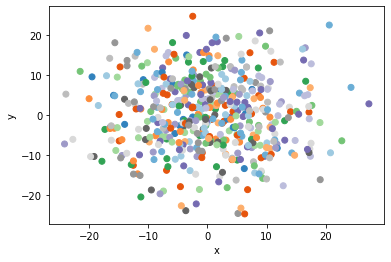

-18


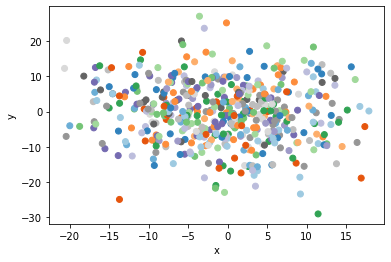

-17


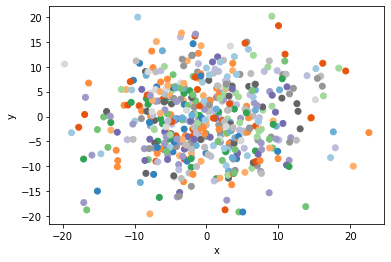

-16


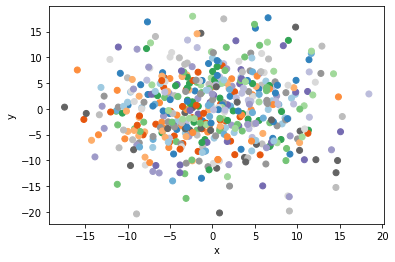

-15


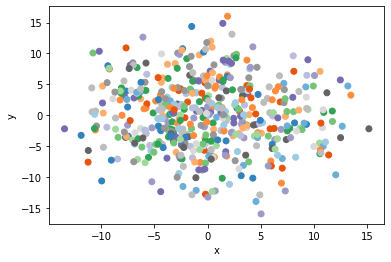

-14


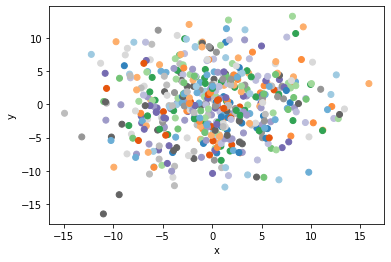

-13


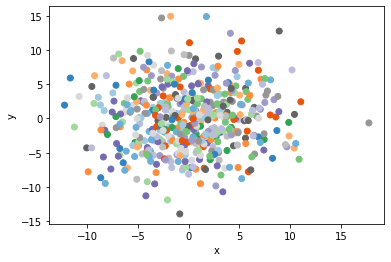

-12


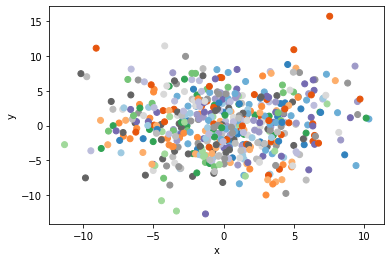

-11


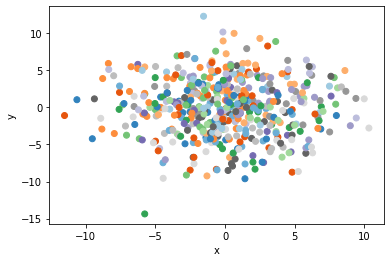

-10


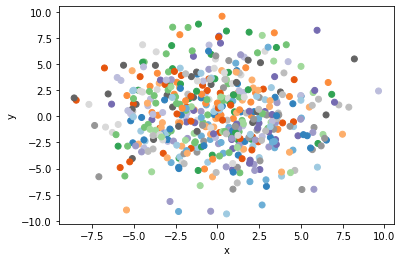

-9


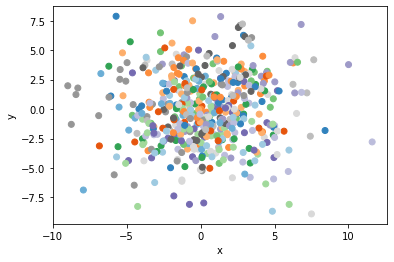

-8


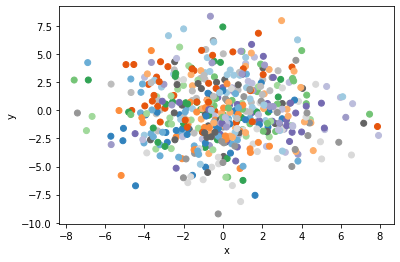

-7


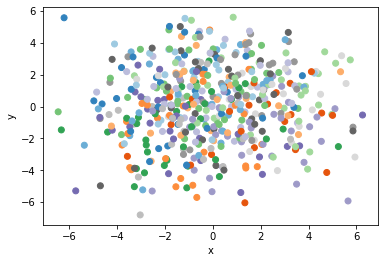

-6


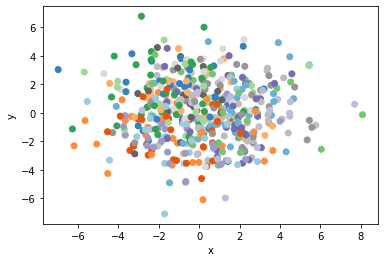

-5


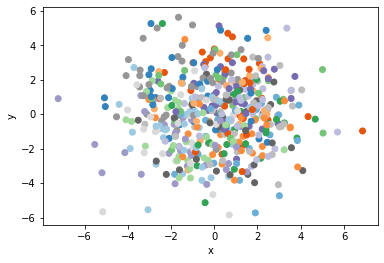

-4


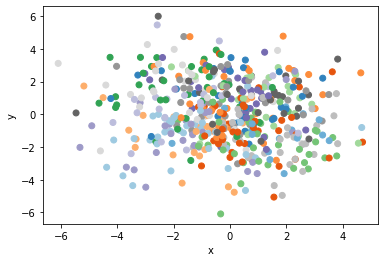

-3


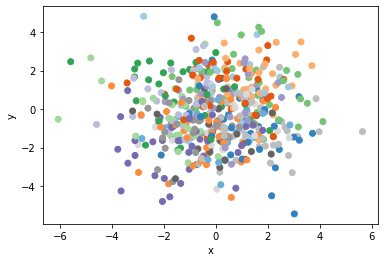

-2


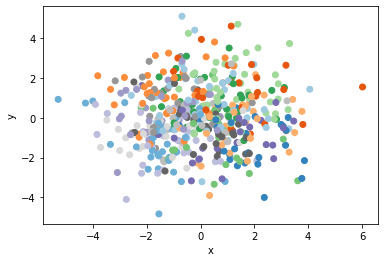

-1


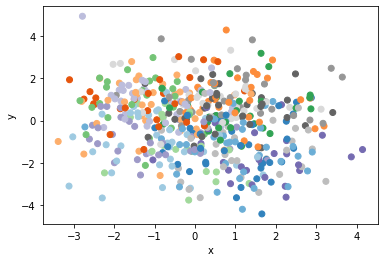

0


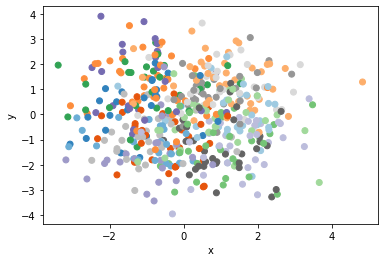

1


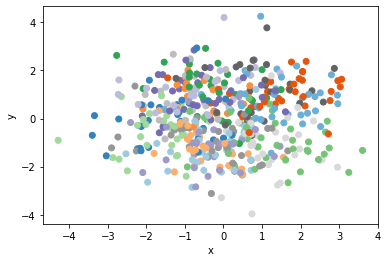

2


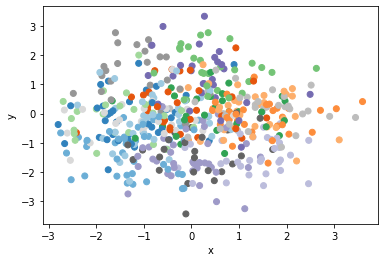

3


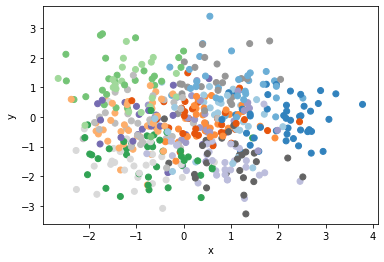

4


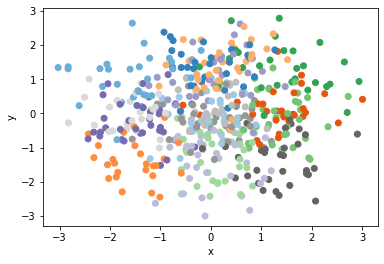

5


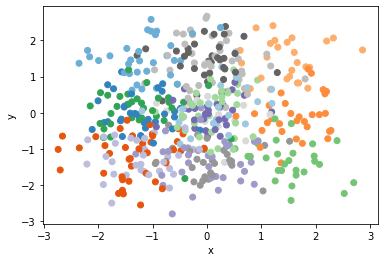

6


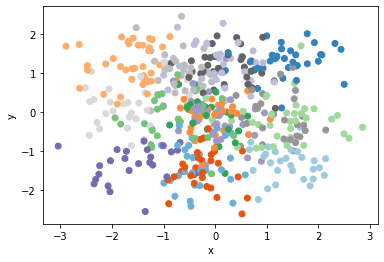

7


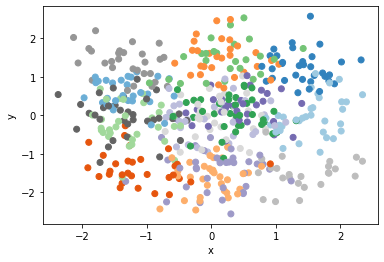

8


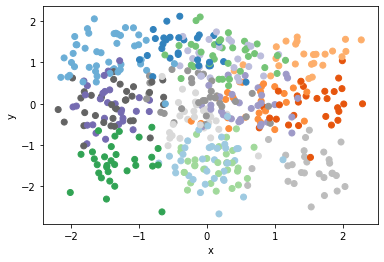

9


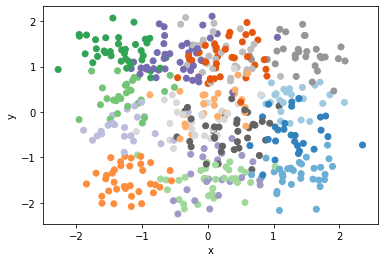

10


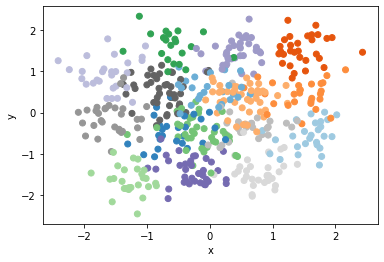

11


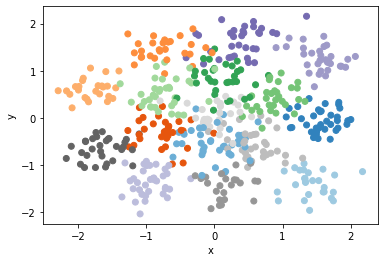

12


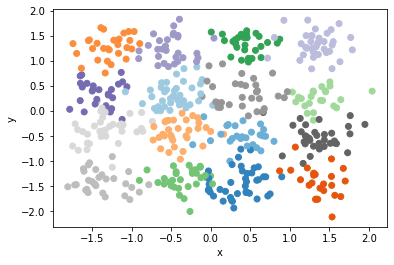

13


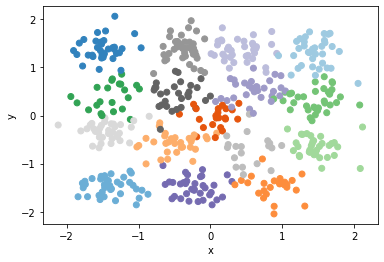

14


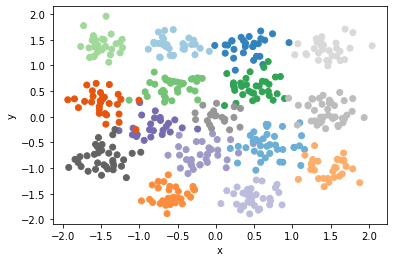

15


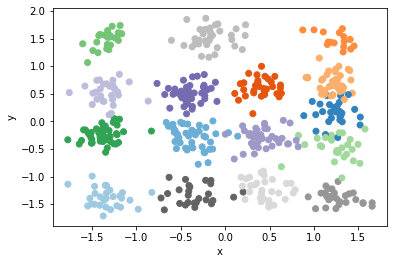

16


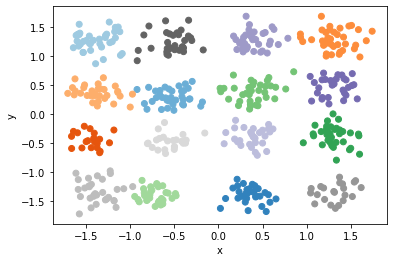

17


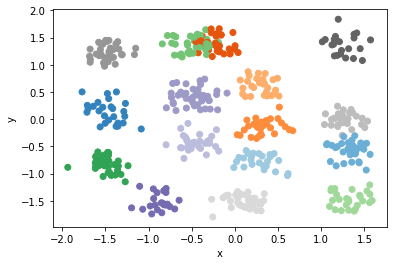

18


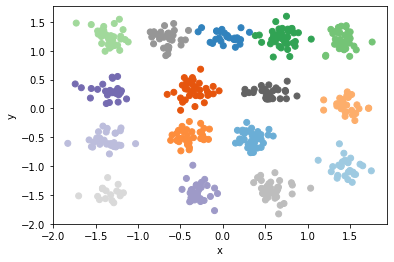

19


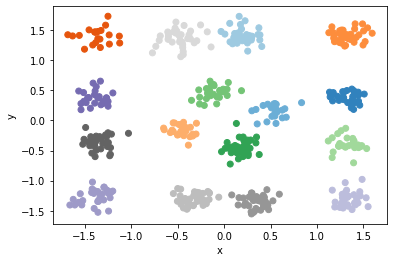

20


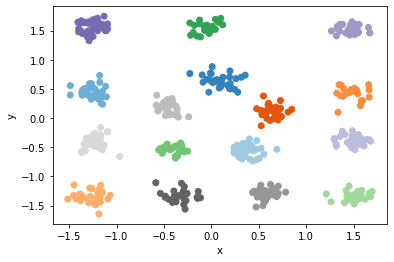

In [9]:
for i in range(len(SNR_dB)):
    print(SNR_dB[i])
    plt.figure()
    plt.scatter(y_total[i,:,0], y_total[i,:,1], c=s_input[i],cmap=plt.get_cmap('tab20c'))
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()
